# Analysis of data
In this notebook we'll look at the downloaded data and explore what it tells us

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas
from shapely.geometry import Point, LineString
from datetime import datetime

In [2]:
geo_data_dir = '../data/geo_data'
weather_data_dir = '../data/weather_data'
taxi_zones_file = '../data/taxi_zones'
enriched_taxi_zone_file = '../data/geo_data/taxi_zones.csv'
tripdata_file = '../data/taxi_data/yellow_tripdata_2018-06.csv'

* Load the shape file of NYC (this contains the shape files for each location below) and display it

In [3]:
def get_taxi_zones(taxi_zones_file):
    taxi_zones = geopandas.read_file(taxi_zones_file).set_index('OBJECTID').to_crs({'init': 'epsg:4326'})
    zone_ids = taxi_zones.index.tolist()
    taxi_zones['centroids'] = taxi_zones.geometry.centroid.to_crs({'init': 'epsg:4326'})
    return taxi_zones, zone_ids

,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroids
OBJECTID,,,,,,,
1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445299999996 40.6949959999999,...",POINT (-74.17400027276298 40.69183120640134)
2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,POINT (-73.83129854302199 40.61674529165965)
3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,POLYGON ((-73.84792614099985 40.87134223399993...,POINT (-73.84742223236724 40.86447368477531)
4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133706...,POINT (-73.97696825691764 40.72375214158458)
5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599989...,POINT (-74.18848410184934 40.55265928694552)
6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,POLYGON ((-74.06367318899999 40.60219816599994...,POINT (-74.0717705589514 40.60032414603445)
7,0.107417,0.000390,Astoria,7,Queens,POLYGON ((-73.90413637799996 40.76752031699986...,POINT (-73.91969431946065 40.76149256216355)
8,0.027591,0.000027,Astoria Park,8,Queens,POLYGON ((-73.92334041500001 40.77512891199993...,POINT (-73.92308615750756 40.77855865375055)
9,0.099784,0.000338,Auburndale,9,Queens,POLYGON ((-73.78502434699996 40.76103651599986...,POINT (-73.78794887777896 40.75103502557216)


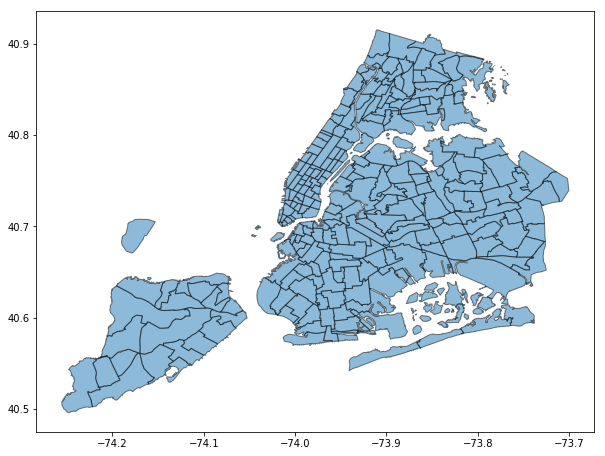

In [4]:
taxi_zones, zone_ids = get_taxi_zones(taxi_zones_file)
taxi_zones.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
taxi_zones.head(10)

* Save taxi zone data with centroids

In [8]:
taxi_zones.to_csv(enriched_taxi_zone_file, sep=',')

### Load the taxi data

Load and cleanse the trip data

In [19]:
def load_tripdata(tripdata_file, zone_ids, min_trip_duration=0, max_trip_duration=120, delimiter=',', save=True): 
    def get_trip_durations(tripdata_file):
        durations = []
        for i, trip in tripdata.iterrows():
            pickup_time = trip['tpep_pickup_datetime']  #"2017-07-01 00:56:23"
            dropoff_time = trip['tpep_dropoff_datetime']  #"2017-07-01 00:59:30"
            duration = datetime.strptime(dropoff_time, '%Y-%m-%d %H:%M:%S') - datetime.strptime(pickup_time, '%Y-%m-%d %H:%M:%S')
            durations.append(duration.seconds / 60)    # Convert to minutes
        return durations
    
    print('Loading trip data from {}'.format(tripdata_file))
    tripdata = pd.read_csv(tripdata_file, delimiter=delimiter).drop(columns=[
                           'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'extra', 'mta_tax', 
                           'tolls_amount', 'improvement_surcharge'])
    print('Trip data contains {} rows'.format(len(tripdata)))
    print('Removing NaNs, zeros, outliers, etc.')
    # Drop rows with zero and NaN values
    tripdata = tripdata[(tripdata != 0).all(1)].dropna()
    # Drop rows outside of NY
    tripdata = tripdata[(tripdata['PULocationID'].isin(zone_ids)) & 
                                (tripdata['DOLocationID'].isin(zone_ids))]
    # Drop rows will outlier fare amounts
    tripdata = tripdata[(0 < tripdata['fare_amount']) & tripdata['fare_amount'] <= 250]
    # Drop rows where pickup and dropoff locations are the same
    tripdata = tripdata[tripdata['PULocationID'] != tripdate['DOLocationID']]
    print('Trip data contains {} rows'.format(len(tripdata)))
    # Get trip durations and remove outliers
    print('Calculating trip durations for {} rows'.format(len(tripdata)))
    tripdata['duration'] = get_trip_durations(tripdata)
    print('Removing rows with {} < duration < {}'.format(min_trip_duration, max_trip_duration))
    tripdata = tripdata[(tripdata['duration'] >= min_trip_duration ) & ( tripdata['duration'] <= max_trip_duration)]
    # Save and return cleansed data
    print('Cleansed trip data contains {} rows'.format(len(tripdata)))
    if save:
        directory = os.path.dirname(tripdata_file)
        file = os.path.basename(tripdata_file)
        cleansed_file = os.path.join(directory, 'cleansed_{}'.format(file))
        print('Saving cleansed data to {}'.format(cleansed_file))
        tripdata.to_csv(cleansed_file, sep=delimiter)
        print('Done')
    return tripdata       

* Load trip data

In [42]:
tripdata = load_tripdata(tripdata_file, zone_ids, save=False)
tripdata.head(10)

Loaded trip data from ../data/taxi_data/yellow_tripdata_2018-06.csv
Trip data contains 8713831 rows
Calculating trip durations for 5598941 rows
Removing rows with 1 < duration < 120
Cleansed trip data contains 5580670 rows


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,tip_amount,total_amount,duration
1,1,2018-06-01 00:04:18,2018-06-01 00:09:18,1,1.00,230,161,1.35,8.15,5.000000
5,1,2018-06-01 00:09:00,2018-06-01 00:24:01,1,2.00,161,234,2.55,15.35,15.016667
6,1,2018-06-01 00:02:33,2018-06-01 00:13:01,2,1.50,163,233,1.95,11.75,10.466667
7,1,2018-06-01 00:13:23,2018-06-01 00:16:52,1,0.70,186,246,1.85,8.15,3.483333
11,1,2018-06-01 00:39:42,2018-06-01 00:57:23,1,3.50,141,179,2.95,17.75,17.683333
12,1,2018-06-01 00:25:43,2018-06-01 00:40:07,1,3.00,138,7,3.45,17.25,14.400000
16,2,2018-06-01 00:02:18,2018-06-01 00:08:05,1,0.75,229,141,4.00,10.80,5.783333
17,2,2018-06-01 00:40:22,2018-06-01 00:52:20,1,3.94,148,233,3.70,18.50,11.966667
18,1,2018-06-01 00:22:51,2018-06-01 00:30:01,1,1.40,142,238,1.75,10.55,7.166667
23,1,2018-06-01 00:09:50,2018-06-01 00:20:33,1,2.80,231,52,2.15,13.95,10.716667


* Graph trip times

Text(0,0.5,'Number of samples')

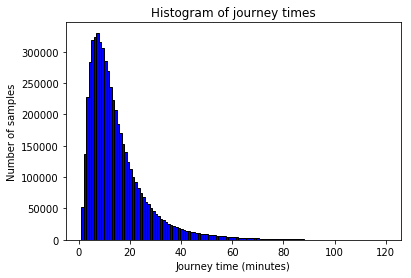

In [43]:
max_dur_to_plot = 120    # Minutes
plt.hist(tripdata[tripdata['duration'] < max_dur_to_plot]['duration'], color = 'blue', edgecolor = 'black',
         bins = int((max_dur_to_plot)))
plt.title('Histogram of journey times')
plt.xlabel('Journey time (minutes)')
plt.ylabel('Number of samples')

### Restart here

Start by loading the CSV (avoids processing the file again if we've already done that!)

In [67]:
tripdata = pd.read_csv('../data/taxi_data/cleansed_yellow_tripdata_2018-06.csv', delimiter=',')

* Count of each pickup (PU) and drop-off (DO) location ID

In [68]:
def count_by_location_ids(tripdata):
    count_by_PU = tripdata.groupby('PULocationID')['PULocationID'].count()
    count_by_DO = tripdata.groupby('DOLocationID')['DOLocationID'].count()
    return count_by_PU, count_by_DO

In [69]:
taxi_zones['Count_by_PULocationID'], taxi_zones['Count_by_DOLocationID'] = count_by_location_ids(tripdata)
taxi_zones.head(10)

,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroids,centroids_x,centroids_y,Count_by_PULocationID,Count_by_DOLocationID
OBJECTID,,,,,,,,,,,
1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445299999996 40.6949959999999,...",POINT (-74.17400027276298 40.69183120640134),-74.174000,40.691831,32.0,12152.0
2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,POINT (-73.83129854302199 40.61674529165965),-73.831299,40.616745,2.0,1.0
3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,POLYGON ((-73.84792614099985 40.87134223399993...,POINT (-73.84742223236724 40.86447368477531),-73.847422,40.864474,12.0,207.0
4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133706...,POINT (-73.97696825691764 40.72375214158458),-73.976968,40.723752,10815.0,24444.0
5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599989...,POINT (-74.18848410184934 40.55265928694552),-74.188484,40.552659,1.0,22.0
6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,POLYGON ((-74.06367318899999 40.60219816599994...,POINT (-74.0717705589514 40.60032414603445),-74.071771,40.600324,2.0,66.0
7,0.107417,0.000390,Astoria,7,Queens,POLYGON ((-73.90413637799996 40.76752031699986...,POINT (-73.91969431946065 40.76149256216355),-73.919694,40.761493,4788.0,20050.0
8,0.027591,0.000027,Astoria Park,8,Queens,POLYGON ((-73.92334041500001 40.77512891199993...,POINT (-73.92308615750756 40.77855865375055),-73.923086,40.778559,66.0,90.0
9,0.099784,0.000338,Auburndale,9,Queens,POLYGON ((-73.78502434699996 40.76103651599986...,POINT (-73.78794887777896 40.75103502557216),-73.787949,40.751035,15.0,360.0


* This CRS will transform the map into lat/long coordinates (commented out for reference)

In [70]:
#taxi_zones_crs = taxi_zones.crs
#print(taxi_zones_crs)
# taxi_zones = taxi_zones.to_crs({'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True})

### Plot volumes of pickups by zone on the map

In [71]:
def plot_volumes_by_location(taxi_zones, column, title, figsize=(10,10), cmap='Blues', scheme='quantiles'):
    fig, ax = plt.subplots(1, figsize=figsize)
    taxi_zones.plot(column=column, cmap=cmap, scheme=scheme, linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.set_title(title, fontdict={'fontsize': 25, 'fontweight' : 3})

/anaconda3/envs/py36/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/envs/py36/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/anac

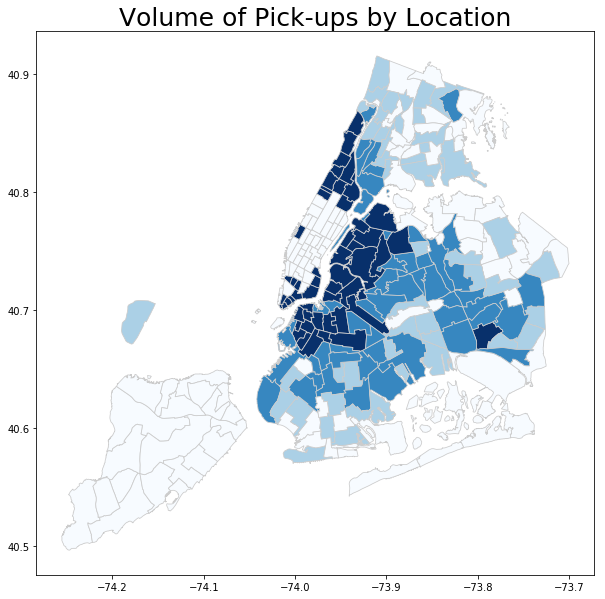

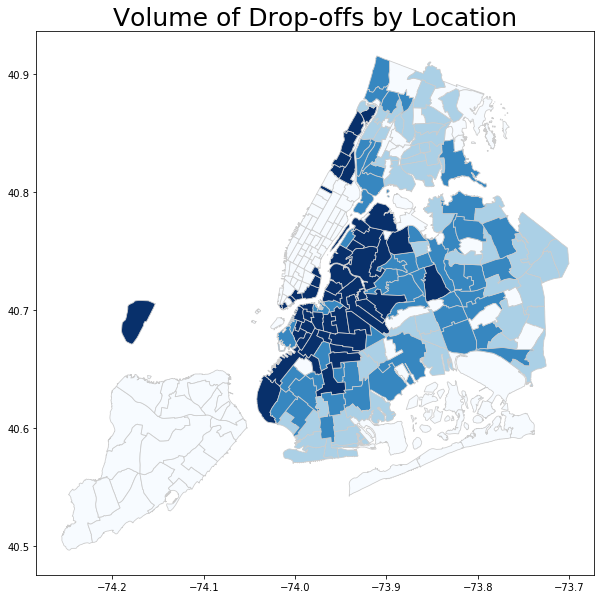

In [72]:
plot_volumes_by_location(taxi_zones, 'Count_by_PULocationID', 'Volume of Pick-ups by Location')
plot_volumes_by_location(taxi_zones, 'Count_by_DOLocationID', 'Volume of Drop-offs by Location')

* Now calculate the number of trips by unique pickup/drop-off combination

In [73]:
def calc_unique_trips_by_locations(tripdata):
    counts_by_trip = tripdata.groupby(['PULocationID', 'DOLocationID'])[['PULocationID', 'DOLocationID']].size().reset_index()
    counts_by_trip.rename(columns={0: 'count'}, inplace=True)
    return counts_by_trip

In [74]:
counts_by_trip = calc_unique_trips_by_locations(tripdata)
counts_by_trip.head(10)

,PULocationID,DOLocationID,count
0,1,1,15
1,1,13,1
2,1,24,1
3,1,67,1
4,1,75,1
5,1,80,1
6,1,113,1
7,1,125,1
8,1,138,2
9,1,151,1


* Determine linestrings for each unique trip

In [75]:
def get_trip_linestrings(taxi_zones, counts_by_trip):
    journeys = []
    for i, journey in counts_by_trip.iterrows():
        #print(journey[['PULocationID', 'DOLocationID']].values)
        start_centroid = taxi_zones.loc[journey['PULocationID'], 'centroids']
        end_centroid = taxi_zones.loc[journey['DOLocationID'], 'centroids']
        journeys.append(LineString([start_centroid, end_centroid]))
    return journeys

In [76]:
counts_by_trip['journey'] = get_trip_linestrings(taxi_zones, counts_by_trip)
counts_by_trip.head(10)

,PULocationID,DOLocationID,count,journey
0,1,1,15,LINESTRING (-74.17400027276298 40.691831206401...
1,1,13,1,LINESTRING (-74.17400027276298 40.691831206401...
2,1,24,1,LINESTRING (-74.17400027276298 40.691831206401...
3,1,67,1,LINESTRING (-74.17400027276298 40.691831206401...
4,1,75,1,LINESTRING (-74.17400027276298 40.691831206401...
5,1,80,1,LINESTRING (-74.17400027276298 40.691831206401...
6,1,113,1,LINESTRING (-74.17400027276298 40.691831206401...
7,1,125,1,LINESTRING (-74.17400027276298 40.691831206401...
8,1,138,2,LINESTRING (-74.17400027276298 40.691831206401...
9,1,151,1,LINESTRING (-74.17400027276298 40.691831206401...


In [77]:
# journeys = geopandas.GeoDataFrame(counts_by_trip, geometry='journey')
# journeys.plot(figsize=(15, 15), color='red')

* Now plot on the map of NYC

In [78]:
def plot_trips(taxi_zones, counts_by_trip, column, title, figsize=(10,10), cmap='Blues', scheme='quantiles'):
    ax = taxi_zones.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
    journeys = geopandas.GeoDataFrame(counts_by_trip, geometry='journey')
    # journeys.crs = taxi_zones.crs  #{'init': 'epsg:4326'}
    # journeys.to_crs(taxi_zones.crs)
    journeys.plot(ax=ax, color='red')
    ax.set_title(title, fontdict={'fontsize': 25, 'fontweight' : 3})

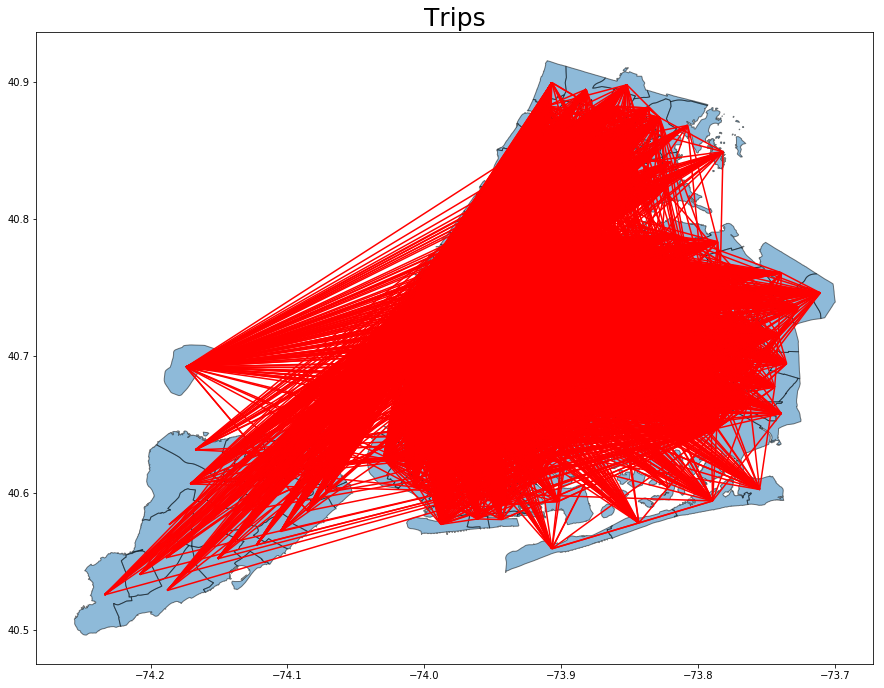

In [79]:
plot_trips(taxi_zones, counts_by_trip, 'journey', 'Trips')

### Trip meta-data

In [80]:
trip_meta = pd.DataFrame()
for i, unique_trip in counts_by_trip.iterrows():
    PULocationID = unique_trip['PULocationID']
    DOLocationID = unique_trip['DOLocationID']
    unique_trip_samples = tripdata[(tripdata['PULocationID'] == PULocationID) & (tripdata['DOLocationID'] == DOLocationID)]
    min_trip_time = unique_trip_samples['duration'].min()
    max_trip_time = unique_trip_samples['duration'].max()
    mean_trip_time = unique_trip_samples['duration'].mean()
    min_trip_dist = unique_trip_samples['trip_distance'].min()
    max_trip_dist = unique_trip_samples['trip_distance'].max()
    mean_trip_dist = unique_trip_samples['trip_distance'].mean()
    min_trip_amnt = unique_trip_samples['total_amount'].min()
    max_trip_amnt = unique_trip_samples['total_amount'].max()
    mean_trip_amnt = unique_trip_samples['total_amount'].mean()
    key = '{:03d}-{:03d}'.format(PULocationID, DOLocationID)
    trip_meta = trip_meta.append({
        'key': key, 
        'min_trip_time': min_trip_time,
        'max_trip_time': max_trip_time,
        'mean_trip_time': mean_trip_time,
        'min_trip_dist': min_trip_dist, 
        'max_trip_dist': max_trip_dist,
        'mean_trip_dist': max_trip_dist,
        'min_trip_amnt': min_trip_amnt,
        'max_trip_amnt': max_trip_amnt,
        'mean_trip_amnt': mean_trip_amnt
    }, ignore_index=True)          

In [81]:
trip_meta.set_index('key')

,max_trip_amnt,max_trip_dist,max_trip_time,mean_trip_amnt,mean_trip_dist,mean_trip_time,min_trip_amnt,min_trip_dist,min_trip_time
key,,,,,,,,,
001-001,133.55,17.60,13.450000,80.454667,17.60,3.396667,11.80,0.03,1.016667
001-013,90.36,14.62,47.583333,90.360000,14.62,47.583333,90.36,14.62,47.583333
001-024,109.59,19.85,41.900000,109.590000,19.85,41.900000,109.59,19.85,41.900000
001-067,155.09,39.27,72.416667,155.090000,39.27,72.416667,155.09,39.27,72.416667
001-075,105.95,21.00,48.900000,105.950000,21.00,48.900000,105.95,21.00,48.900000
001-080,100.80,16.50,35.683333,100.800000,16.50,35.683333,100.80,16.50,35.683333
001-113,95.76,15.16,33.783333,95.760000,15.16,33.783333,95.76,15.16,33.783333
001-125,80.16,14.02,23.850000,80.160000,14.02,23.850000,80.16,14.02,23.850000
001-138,125.35,25.90,60.950000,109.995000,25.90,60.325000,94.64,24.70,59.700000


In [82]:
import pickle
pickle.dump(trip_meta, open('../data/taxi_data/yellow_taximeta_2018-06.p', "wb"))